## Read ALL WISE images for by-eye inspection

In [1]:
import os, glob, getpass, sys, warnings

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack, hstack, Column, MaskedColumn, unique
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u

user = getpass.getuser()
sys.path.append('/Users/' + user + '/Dropbox/my_python_packages')
path = '../'
sys.path.append(path)
from extra_codes    import sample_comp    as samp_comp

In [2]:
# WISE PSFs ============================================
# http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4c.html#psf)
wbands = ['W1', 'W2', 'W3', 'W4']
psf_M  = [6.08, 6.84, 7.36, 11.99]
psf_m  = [5.60, 6.12, 6.08, 11.65]
psf_a  = [3.  , 15,   6,    0]

wise_psfs = Table([wbands, psf_M, psf_m, psf_a], names = ['Band', 'PSF_M', 'PSF_m', 'PSF_A'])
wise_psfs['PSF_M'].unit = u.arcsecond
wise_psfs['PSF_m'].unit = u.arcsecond
wise_psfs['PSF_A'].unit = u.degree

pxscl = 1.35 # Arcsecs/Px  # WISE Pixel size (same for all bands):

for col in ['PSF_M', 'PSF_m']:
    wise_psfs[col + '_px']        = wise_psfs[col]/pxscl
    wise_psfs[col + '_px'].format = '3.2f'
    wise_psfs[col + '_px'].unit   = u.pixel
    
wise_psfs.write('09_make_WISE_maps_WPSFs.vot', format = 'votable', overwrite = True) # Useful for NBK: 11_make_WISE_NEW_maps
wise_psfs

Band,PSF_M,PSF_m,PSF_A,PSF_M_px,PSF_m_px
,arcsec,arcsec,deg,pix,pix
str2,float64,float64,float64,float64,float64
W1,6.08,5.6,3.0,4.50,4.15
W2,6.84,6.12,15.0,5.07,4.53
W3,7.36,6.08,6.0,5.45,4.50
W4,11.99,11.65,0.0,8.88,8.63


In [3]:
# Find Images inside directory ================
path_wise     = path + '../extra_data/WISE_data/WISE_ALL/'
wise_fits     = glob.glob(path_wise + '*fits')
wise_fits_W1  = [file for file in wise_fits if 'w1' in file]                            # Extract W1 observations
wise_ra       = [file[file.find('_ra')+3: file.find('_dec')]  for file in wise_fits_W1] # Extract RA  coords
wise_dec      = [file[file.find('_dec')+4:file.find('_asec')] for file in wise_fits_W1] # Extract Dec coords
wise_coords_f = Table([wise_ra, wise_dec], names = ['wise_ra', 'wise_dec'])
wise_coords_f.sort('wise_ra')

In [4]:
# Read WISE/IPAC input file ===================
wise_coords = Table.read('08_IR_crossmatch_WISE_check.txt', format = 'ipac')
wise_dat    = hstack([wise_coords, wise_coords_f])

for col in ['ra', 'dec']:
    wise_dat['diff_' + col] = wise_dat[col]  - [np.float(inp) for inp in wise_dat['wise_' + col]]
    wise_dat['diff_' + col].format = '3.2e'
wise_dat[0:3]

ra,dec,source_id,artifact,wise_ra,wise_dec,diff_ra,diff_dec
deg,deg,,,,,deg,deg
float64,float64,int64,str1,str16,str17,float64,float64
244.34004994892663,-23.416885441288162,6050346856816823552,N,244.340049948927,-23.4168854412882,-3.69e-13,3.91e-14
244.46152573259377,-22.30280407533479,6050574730599548288,N,244.461525732594,-22.3028040753348,-2.27e-13,1.07e-14
244.56018406553224,-23.3237856296886,6050352010777437952,N,244.560184065532,-23.3237856296886,2.27e-13,0.00e+00


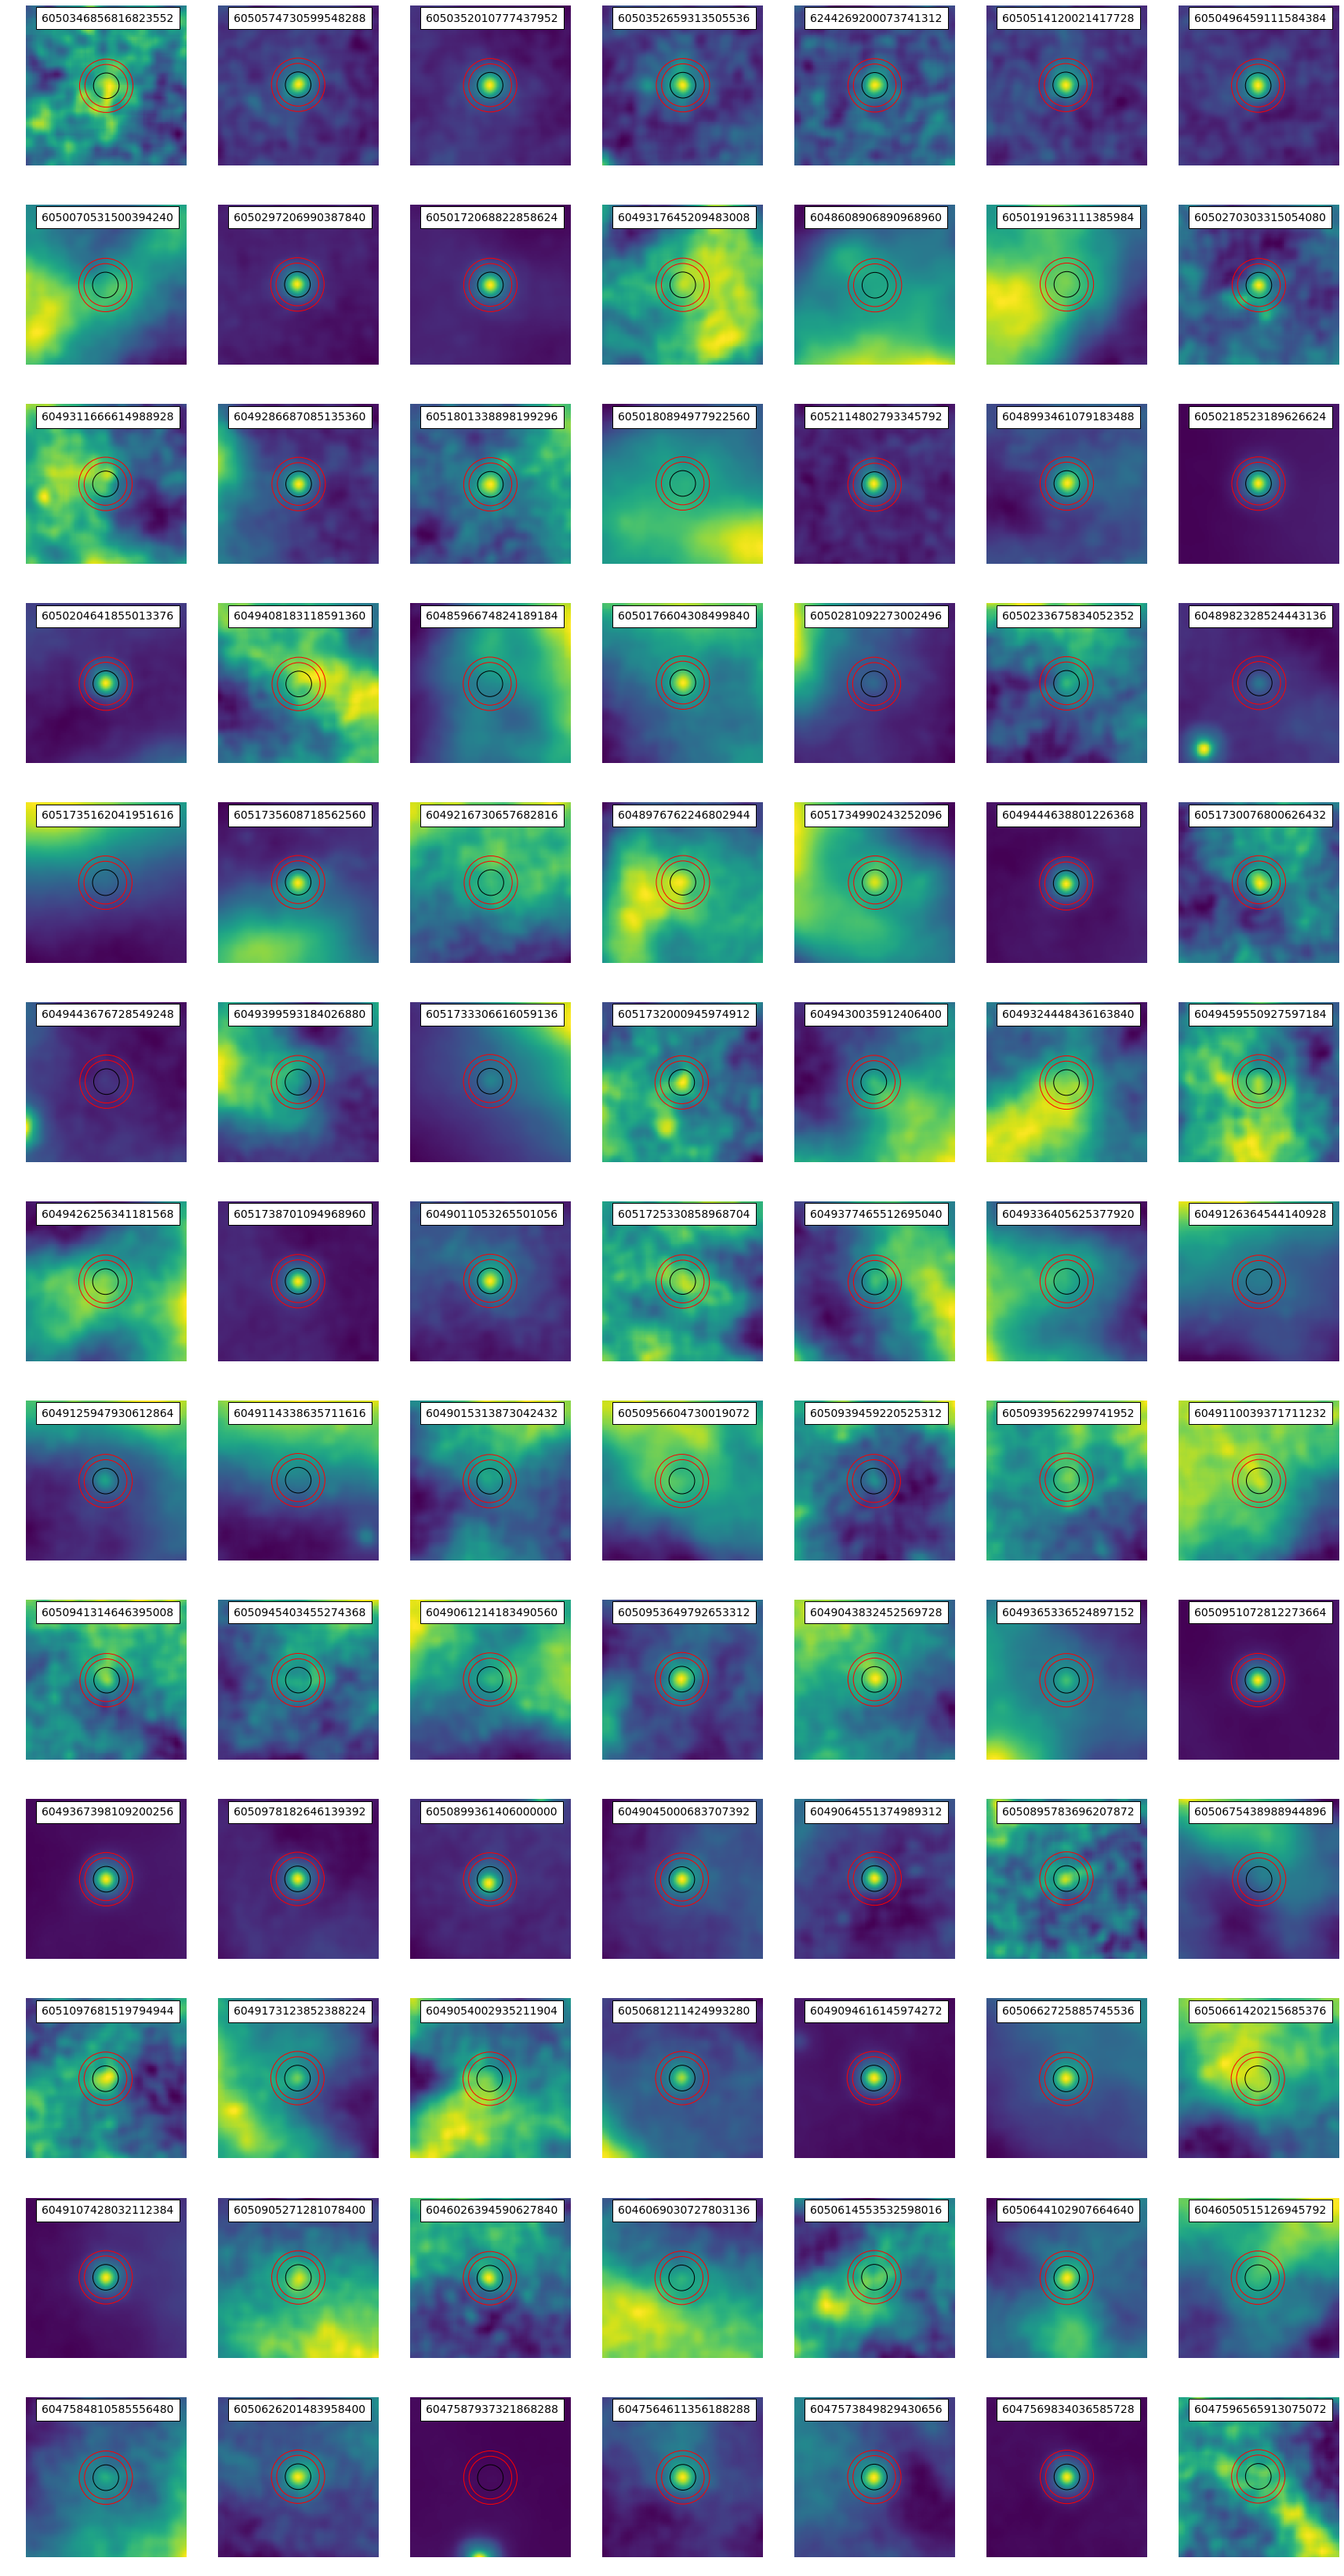

In [5]:
# Compute SN at WISE B4 & show B4 images ======
table_wise = wise_dat
band       = 'w4'
filename   = '09_make_WISE_maps_0' + band + '.pdf'
wise_phot  = samp_comp.wise_multiphot_09(path_wise=path_wise, table_wise=table_wise, band=band, filename=filename)
wise_phot.rename_column('SN', 'SN_W4')

In [6]:
# Save Data ===================================
wise_dat = join(wise_dat, wise_phot, keys='source_id')
wise_dat.sort('ra')
wise_dat['SN_W4'].format = '3.1f'
wise_dat.write('09_make_WISE_maps_0_w4_SN.vot', format = 'votable', overwrite = True)